In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1uDFKSWW0UpRu4JZ8_ZdgsKtV7-wGMSTz'})

In [0]:
download.GetContentFile('Dataset.zip')
!unzip Dataset.zip

Archive:  Dataset.zip
   creating: Dataset/
  inflating: Dataset/zero_indexed_files.csv  
   creating: __MACOSX/
   creating: __MACOSX/Dataset/
  inflating: __MACOSX/Dataset/._zero_indexed_files.csv  
  inflating: Dataset/.DS_Store       
  inflating: __MACOSX/Dataset/._.DS_Store  
  inflating: Dataset/test_notrash.csv  
  inflating: __MACOSX/Dataset/._test_notrash.csv  
   creating: Dataset/Garbage classification/
   creating: Dataset/Garbage classification/paper/
  inflating: Dataset/Garbage classification/paper/paper283.jpg  
   creating: __MACOSX/Dataset/Garbage classification/
   creating: __MACOSX/Dataset/Garbage classification/paper/
  inflating: __MACOSX/Dataset/Garbage classification/paper/._paper283.jpg  
  inflating: Dataset/Garbage classification/paper/paper297.jpg  
  inflating: __MACOSX/Dataset/Garbage classification/paper/._paper297.jpg  
  inflating: Dataset/Garbage classification/paper/paper526.jpg  
  inflating: __MACOSX/Dataset/Garbage classification/paper/._paper526

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tqdm import tqdm
%tensorflow_version 1.x
import glob, os, random

Using TensorFlow backend.


In [0]:
train = pd.read_csv('Dataset/zero_indexed_files.csv')
train.head

<bound method NDFrame.head of              image  label
0       glass1.jpg      0
1       glass2.jpg      0
2       glass3.jpg      0
3       glass4.jpg      0
4       glass5.jpg      0
...            ...    ...
2522  trash133.jpg      5
2523  trash134.jpg      5
2524  trash135.jpg      5
2525  trash136.jpg      5
2526  trash137.jpg      5

[2527 rows x 2 columns]>

In [0]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
train_image = []
for i in tqdm(range(train.shape[0])):
    if("glass" in train['image'][i]):
      img = image.load_img('Dataset/Garbage classification/glass/'+train['image'][i], target_size=(28,28,1), grayscale=False)
    elif("paper" in train['image'][i]):
      img = image.load_img('Dataset/Garbage classification/paper/'+train['image'][i], target_size=(28,28,1), grayscale=False)
    elif("cardboard" in train['image'][i]):
      img = image.load_img('Dataset/Garbage classification/cardboard/'+train['image'][i], target_size=(28,28,1), grayscale=False)
    elif("plastic" in train['image'][i]):
      img = image.load_img('Dataset/Garbage classification/plastic/'+train['image'][i], target_size=(28,28,1), grayscale=False)
    elif("metal" in train['image'][i]):
      img = image.load_img('Dataset/Garbage classification/metal/'+train['image'][i], target_size=(28,28,1), grayscale=False)
    elif("trash" in train['image'][i]):
      img = image.load_img('Dataset/Garbage classification/trash/'+train['image'][i], target_size=(28,28,1), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)

X = np.array(train_image)

/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
  1%|          | 30/2527 [00:00<00:08, 296.29it/s]

Populating the interactive namespace from numpy and matplotlib


100%|██████████| 2527/2527 [00:07<00:00, 351.10it/s]


In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob, os, random
base_path = 'Dataset/Garbage classification'
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed=0
)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [0]:
IMG_SHAPE = (224,224,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
9412608/9406464 [==============================] - 1s 0us/step


In [0]:
base_model.trainable = False

In [0]:
from tensorflow import keras
model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(6, activation='relu')
])

In [0]:
# model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), 
#               loss='categorical_crossentropy', 
#               metrics=['accuracy'])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [0]:
batch_size = 32
epochs = 10
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit_generator(train_generator, 
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs, 
                              workers=4,
                              validation_data=validation_generator, 
                              validation_steps=validation_steps)

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
71/71 [==============================] - 124s 2s/step - loss: 2.4176 - acc: 0.8277 - val_loss: 2.5259 - val_acc: 0.8363
Epoch 2/10
71/71 [==============================] - 119s 2s/step - loss: 2.3262 - acc: 0.8393 - val_loss: 2.5491 - val_acc: 0.8333
Epoch 3/10
71/71 [==============================] - 122s 2s/step - loss: 2.3225 - acc: 0.8448 - val_loss: 2.5507 - val_acc: 0.8333
Epoch 4/10
71/71 [==============================] - 118s 2s/step - loss: 2.3460 - acc: 0.8403 - val_loss: 2.5492 - val_acc: 0.8333
Epoch 5/10
71/71 [==============================] - 121s 2s/step - loss: 2.2732 - acc: 0.8480 - val_loss: 2.5708 - val_acc: 0.8333
Epoch 6/10
71/71 [==============================] - 120s 2s/step - loss: 2.3027 - acc: 0.8457 - val_loss: 2.5708 - val_acc: 0.8333
Epoch 7/10
71/71 [==============================] - 122s 2s/step - loss: 2.2856 - acc: 0.8468 - val_loss: 2.5708 - val_a

0.85108566


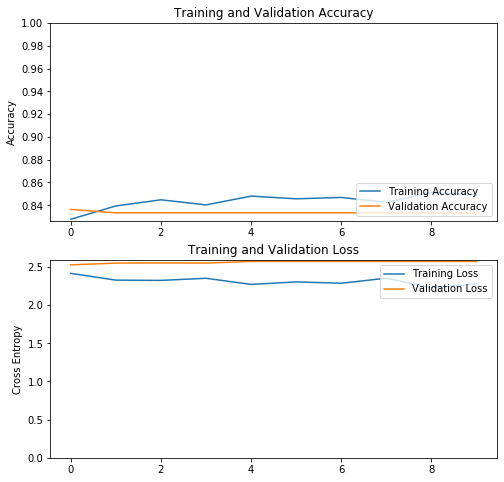

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
print(np.amax(acc))
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [0]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [0]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 1,870,278
Non-trainable params: 395,392
_________________________________________________________________


In [0]:
history_fine = model.fit_generator(train_generator, 
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=epochs, 
                                   workers=4,
                                   validation_data=validation_generator, 
                                   validation_steps=validation_steps)

Epoch 1/10
71/71 [==============================] - 118s 2s/step - loss: 2.2762 - acc: 0.8479 - val_loss: 2.5708 - val_acc: 0.8333
Epoch 2/10
71/71 [==============================] - 114s 2s/step - loss: 2.2587 - acc: 0.8505 - val_loss: 2.5708 - val_acc: 0.8333
Epoch 3/10
71/71 [==============================] - 116s 2s/step - loss: 2.2616 - acc: 0.8473 - val_loss: 2.5708 - val_acc: 0.8333
Epoch 4/10
71/71 [==============================] - 114s 2s/step - loss: 2.3020 - acc: 0.8464 - val_loss: 2.5708 - val_acc: 0.8333
Epoch 5/10
71/71 [==============================] - 116s 2s/step - loss: 2.2309 - acc: 0.8511 - val_loss: 2.5708 - val_acc: 0.8333
Epoch 6/10
71/71 [==============================] - 111s 2s/step - loss: 2.4680 - acc: 0.8348 - val_loss: 2.5275 - val_acc: 0.8348
Epoch 7/10
71/71 [==============================] - 114s 2s/step - loss: 2.4641 - acc: 0.8388 - val_loss: 2.5708 - val_acc: 0.8333
Epoch 8/10
71/71 [==============================] - 111s 2s/step - loss: 2.5708 - a

In [0]:
import numpy as np
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']
print(np.amax(val_acc))
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

0.83630955


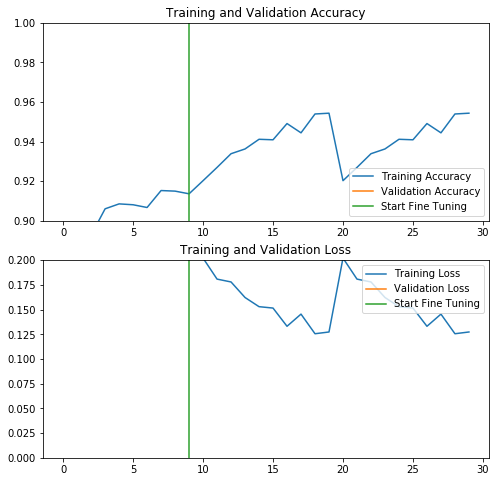

In [0]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.9, 1])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.2])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

AttributeError: ignored